<a href="https://colab.research.google.com/github/nilsoncunha/portfolio/blob/master/Prevendo_nota_de_matematica_do_ENEM_2016.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Prevendo as notas de matemática do ENEM do ano de **2016**

In [0]:
# importando as bibliotecas

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import scipy.stats as sct

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder

import plotly.graph_objects as go

import pickle

In [0]:
import warnings
warnings.filterwarnings('ignore')

from IPython.core.pylabtools import figsize
figsize(15, 8)
sns.set(style='darkgrid')

In [0]:
train = pd.read_csv('https://dl.dropbox.com/s/7vexlzohz7j3qem/train.csv?dl=0', index_col=0)
test = pd.read_csv('https://dl.dropbox.com/s/dsgzaemaau9g5z0/test.csv?dl=0')

### Realizando a análise descritiva dos dados

In [0]:
train.head()

,NU_INSCRICAO,NU_ANO,CO_MUNICIPIO_RESIDENCIA,NO_MUNICIPIO_RESIDENCIA,CO_UF_RESIDENCIA,SG_UF_RESIDENCIA,NU_IDADE,TP_SEXO,TP_ESTADO_CIVIL,TP_COR_RACA,TP_NACIONALIDADE,CO_MUNICIPIO_NASCIMENTO,NO_MUNICIPIO_NASCIMENTO,CO_UF_NASCIMENTO,SG_UF_NASCIMENTO,TP_ST_CONCLUSAO,TP_ANO_CONCLUIU,TP_ESCOLA,TP_ENSINO,IN_TREINEIRO,CO_ESCOLA,CO_MUNICIPIO_ESC,NO_MUNICIPIO_ESC,CO_UF_ESC,SG_UF_ESC,TP_DEPENDENCIA_ADM_ESC,TP_LOCALIZACAO_ESC,TP_SIT_FUNC_ESC,IN_BAIXA_VISAO,IN_CEGUEIRA,IN_SURDEZ,IN_DEFICIENCIA_AUDITIVA,IN_SURDO_CEGUEIRA,IN_DEFICIENCIA_FISICA,IN_DEFICIENCIA_MENTAL,IN_DEFICIT_ATENCAO,IN_DISLEXIA,IN_DISCALCULIA,IN_AUTISMO,IN_VISAO_MONOCULAR,...,Q011,Q012,Q013,Q014,Q015,Q016,Q017,Q018,Q019,Q020,Q021,Q022,Q023,Q024,Q025,Q026,Q027,Q028,Q029,Q030,Q031,Q032,Q033,Q034,Q035,Q036,Q037,Q038,Q039,Q040,Q041,Q042,Q043,Q044,Q045,Q046,Q047,Q048,Q049,Q050
1,ed50e8aaa58e7a806c337585efee9ca41f1eb1ad,2016,4314902,Porto Alegre,43,RS,24,M,0.0,1,1,4314902.0,Porto Alegre,43.0,RS,1,4,1,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,...,A,B,A,A,A,A,A,A,B,A,A,C,A,A,A,C,H,E,5.0,5.0,1.0,0.0,0.0,5,5,0,5,5,5,5,5.0,A,A,A,A,A,A,A,B,D
2,2c3acac4b33ec2b195d77e7c04a2d75727fad723,2016,2304707,Granja,23,CE,17,F,0.0,3,1,2304707.0,Granja,23.0,CE,2,0,2,1.0,0,23005157.0,2304707.0,Granja,23.0,CE,2.0,1.0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,...,A,B,A,A,A,A,A,A,B,A,A,A,A,A,A,A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5,5,1,1,1,1,1,NaN,A,A,C,A,B,A,A,C,A
3,f4545f8ccb9ff5c8aad7d32951b3f251a26e6568,2016,2304400,Fortaleza,23,CE,21,F,0.0,3,1,2304400.0,Fortaleza,23.0,CE,3,0,1,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,...,A,B,A,A,A,A,A,A,B,A,A,B,A,A,A,A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5,5,5,5,5,5,5,NaN,A,A,A,A,C,A,A,B,A
4,3d6ec248fef899c414e77f82d5c6d2bffbeaf7fe,2016,3304557,Rio de Janeiro,33,RJ,25,F,0.0,0,1,3304557.0,Rio de Janeiro,33.0,RJ,1,9,1,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,...,A,B,B,B,A,B,A,B,C,A,B,D,B,C,B,C,F,C,2.0,0.0,5.0,5.0,5.0,5,5,5,5,2,5,5,5.0,C,A,A,A,A,D,A,A,A
5,bf896ac8d3ecadd6dba1dfbf50110afcbf5d3268,2016,1302603,Manaus,13,AM,28,M,0.0,2,1,1505304.0,Oriximiná,15.0,PA,1,4,1,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,...,A,B,A,B,A,A,A,A,B,A,A,B,A,A,A,B,F,D,5.0,4.0,3.0,5.0,4.0,5,5,4,3,1,4,5,NaN,A,A,A,A,A,A,A,A,A


Vamos verificar como está distribuido nosso dataset

In [0]:
print(f'Treino: {train.shape[0]} linhas e {train.shape[1]} colunas (features)')
print(f'Teste: {test.shape[0]} linhas e {test.shape[1]} colunas (features)')

Treino: 13730 linhas e 166 colunas (features)
Teste: 4576 linhas e 47 colunas (features)


In [0]:
train.columns

Index(['NU_INSCRICAO', 'NU_ANO', 'CO_MUNICIPIO_RESIDENCIA',
       'NO_MUNICIPIO_RESIDENCIA', 'CO_UF_RESIDENCIA', 'SG_UF_RESIDENCIA',
       'NU_IDADE', 'TP_SEXO', 'TP_ESTADO_CIVIL', 'TP_COR_RACA',
       ...
       'Q041', 'Q042', 'Q043', 'Q044', 'Q045', 'Q046', 'Q047', 'Q048', 'Q049',
       'Q050'],
      dtype='object', length=166)

In [0]:
test.columns

Index(['NU_INSCRICAO', 'CO_UF_RESIDENCIA', 'SG_UF_RESIDENCIA', 'NU_IDADE',
       'TP_SEXO', 'TP_COR_RACA', 'TP_NACIONALIDADE', 'TP_ST_CONCLUSAO',
       'TP_ANO_CONCLUIU', 'TP_ESCOLA', 'TP_ENSINO', 'IN_TREINEIRO',
       'TP_DEPENDENCIA_ADM_ESC', 'IN_BAIXA_VISAO', 'IN_CEGUEIRA', 'IN_SURDEZ',
       'IN_DISLEXIA', 'IN_DISCALCULIA', 'IN_SABATISTA', 'IN_GESTANTE',
       'IN_IDOSO', 'TP_PRESENCA_CN', 'TP_PRESENCA_CH', 'TP_PRESENCA_LC',
       'CO_PROVA_CN', 'CO_PROVA_CH', 'CO_PROVA_LC', 'CO_PROVA_MT',
       'NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC', 'TP_LINGUA',
       'TP_STATUS_REDACAO', 'NU_NOTA_COMP1', 'NU_NOTA_COMP2', 'NU_NOTA_COMP3',
       'NU_NOTA_COMP4', 'NU_NOTA_COMP5', 'NU_NOTA_REDACAO', 'Q001', 'Q002',
       'Q006', 'Q024', 'Q025', 'Q026', 'Q027', 'Q047'],
      dtype='object')

In [0]:
train.dtypes.value_counts()

int64      78
object     60
float64    28
dtype: int64

In [0]:
test.dtypes.value_counts()

int64      20
object     15
float64    12
dtype: int64

Vamos utilizar a maioria das colunas (_features_) que estão na base _test_ e descartar a maioria da base _train_. A análise dessas _features_ foi realizada através do [dicionário de dados](https://dl.dropbox.com/s/i3ehoty42fs6tua/Dicionario_Dados_Enem_2016.ods?dl=0) (_que é disponibilizado pelo INEP_).

Nesse caso vamos criar uma nova variável que terá todo o conteúdo da base _train_, porém com as mesmas _features_ da base _test_. Na nova variável também terá algumas _features_ da base _train_ que não estão na _test_.

Iremos juntar a base _train_ e _test_, isso ajudará na hora de realizarmos o tratamento desses dados, no qual faremos uma única vez e evita de realizar em um _dataset_ apenas esquecendo de fazer o mesmo tratamento no outro. No momento de gerar nosso modelo iremos separá-los novamente.

In [0]:
train_df = train.copy()
train_df = train_df[test.columns]

train_idx = train_df.shape[0]
test_idx = test.shape[0]

print(train_idx)
print(test_idx)

13730
4576


In [0]:
# Criando o dataframe com as features da variável train
features_train = pd.DataFrame({'TP_PRESENCA_MT': train['TP_PRESENCA_MT'], 
                               'NU_NOTA_MT': train['NU_NOTA_MT']})

train_df = pd.concat([train_df, features_train], axis=1)

In [0]:
train_df = pd.concat(objs=[train_df, test], axis=0, sort=False).reset_index(drop=True)
print(f'base concatenada: {train_df.shape[0]} x {train_df.shape[1]}')

base concatenada: 18306 x 49


In [0]:
# Excluindo algumas features que não utilizaremos.
train_df.drop(['NU_INSCRICAO','CO_PROVA_CN','CO_PROVA_CH','CO_PROVA_LC','CO_PROVA_MT',
               'IN_BAIXA_VISAO','IN_CEGUEIRA','IN_DISCALCULIA','IN_DISLEXIA','IN_GESTANTE',
               'IN_IDOSO','IN_SABATISTA','IN_SURDEZ','Q024','Q026','Q027'], axis=1, inplace=True)

Com essas alterações já conseguimos reduzir a dimensionalidade do nosso dataset, o que fica mais fácil para trabalharmos.

Agora vamos fazer uma avaliação geral da base e visualizar como ficou

In [0]:
base = pd.DataFrame({'tipo': train_df.dtypes,
                     'nulos': train_df.isnull().mean(),
                     'size': (train_df.shape[0] - train_df.isnull().sum()),
                     'unicos': train_df.nunique()})

base.index.name = 'coluna'
base = base.reset_index()
base.sort_values(by=['nulos', 'coluna'])

,coluna,tipo,nulos,size,unicos
0,CO_UF_RESIDENCIA,int64,0.000000,18306,27
10,IN_TREINEIRO,int64,0.000000,18306,2
2,NU_IDADE,int64,0.000000,18306,55
26,Q001,object,0.000000,18306,8
27,Q002,object,0.000000,18306,8
28,Q006,object,0.000000,18306,17
29,Q025,object,0.000000,18306,2
30,Q047,object,0.000000,18306,5
1,SG_UF_RESIDENCIA,object,0.000000,18306,27
7,TP_ANO_CONCLUIU,int64,0.000000,18306,11


Já conseguimos visualizar a correlação entre as nossas _features_ e percebemos que algumas já estão com a correlação forte (próximo de 1)

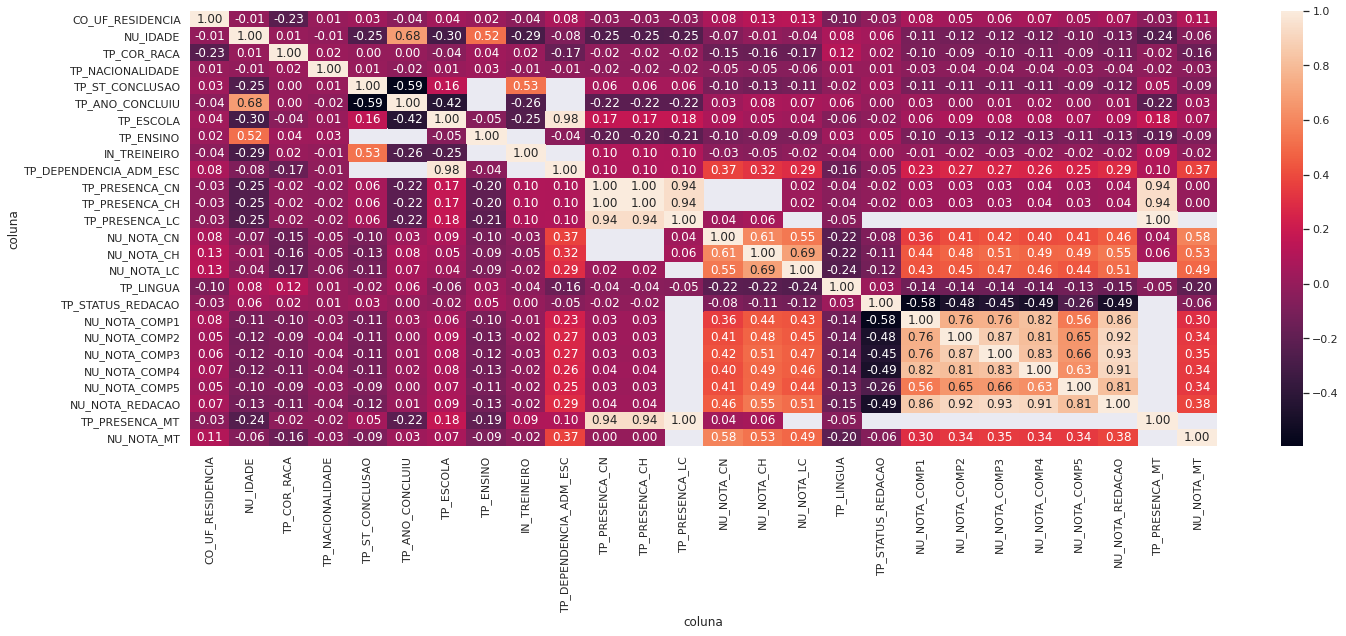

In [0]:
def correlacao(data):
    plt.figure(figsize=(23,8))
    sns.heatmap(data.corr(), annot=True, fmt='.2f')

correlacao(train_df)

A maioria de nossas _features_ não contém dados nulos e isso é bom. Veremos o porquê mais pra frente. Vamos nos preocupar primeiro com as _features_ restante

In [0]:
print(f'Features sem dados nulos: {base.loc[base.nulos == 0, "nulos"].shape[0]}')

Features sem dados nulos: 19


In [0]:
base[base.nulos > 0].sort_values(['nulos', 'coluna'])

,coluna,tipo,nulos,size,unicos
16,NU_NOTA_CH,float64,0.247077,13783,3193
15,NU_NOTA_CN,float64,0.247077,13783,2872
31,TP_PRESENCA_MT,float64,0.249973,13730,3
20,NU_NOTA_COMP1,float64,0.261991,13510,15
21,NU_NOTA_COMP2,float64,0.261991,13510,13
22,NU_NOTA_COMP3,float64,0.261991,13510,12
23,NU_NOTA_COMP4,float64,0.261991,13510,14
24,NU_NOTA_COMP5,float64,0.261991,13510,14
17,NU_NOTA_LC,float64,0.261991,13510,2939
25,NU_NOTA_REDACAO,float64,0.261991,13510,53


Quandos nos deparamos com valores nulos, qual a melhor solução a se tomar? __Depende__. Vai depender principamente da base que estamos analisando. Em alguns casos dizem que trabalhar com _features_ que contém acima de 50% de dados faltantes fica inviável, outros acima de 20%, por ai vai. Mas por exemplo: Digamos que vamos trabalhar com uma base para prever algum tipo de doença, vamos querer o mínimo possível de dados faltantes e olhe lá. Fazer essa análise é o papel do Ciêntista de Dados.

Outro ponto a ser analisado é a questão da imputação dos dados, ou seja, preencher os dados faltantes. Os modelos de Machine Learning não conseguem trabalhar com essas _features_ com campos vazios, com isso temos algumas possibilidades que seria preenchê-las com:

* valor zero,
* a média,
* a mediana,
* remover essas linhas,
* etc. 

Porém mais uma vez, __depende__ de qual análise estamos fazendo e também se não estaremos perdendo dados importantes caso escolhermos removê-las.

Analisando os dados acima já conseguimos eliminar duas _features_ que são _TP_DEPENDENCIA_ADM_ESC_ e _TP_ENSINO_ por terem mais de 50% de dados nulos.


In [0]:
train_df.drop(['TP_DEPENDENCIA_ADM_ESC', 'TP_ENSINO'], axis=1, inplace=True)
base.drop([10, 12], inplace=True)

Antes de realizar a imputação em nossa base vamos fazer algumas análises e tentar tirar algumas conclusões...

Conseguimos ver que o estado de São Paulo teve o maior número de candidados, seguido por Ceará e Minas Gerais.

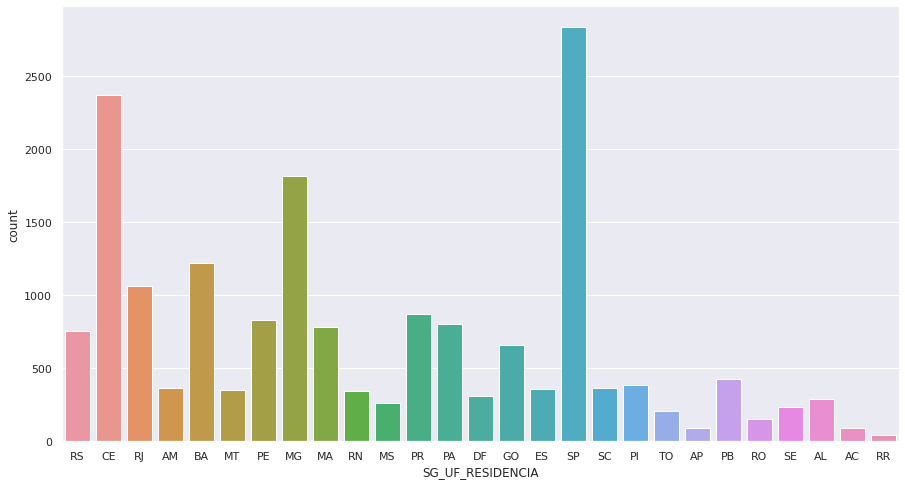

In [0]:
sns.countplot(train_df['SG_UF_RESIDENCIA'])

E que a maior presença foi registrada pelo sexo feminino

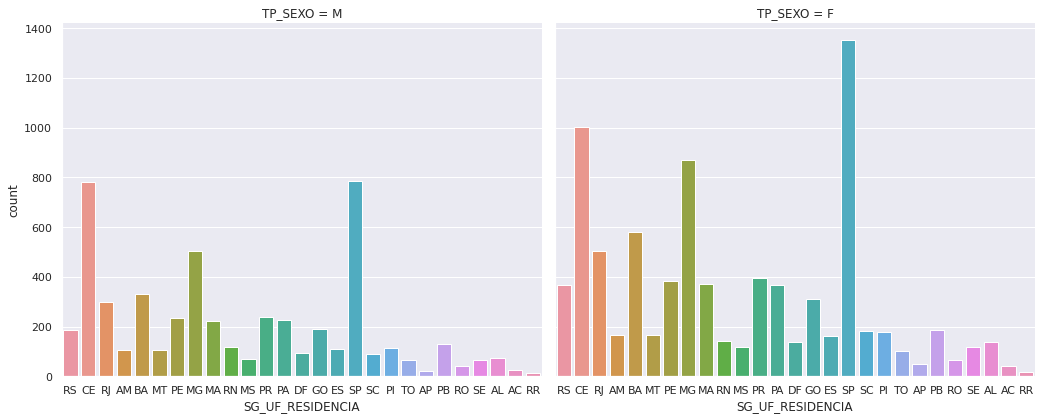

In [0]:
sns.catplot(x='SG_UF_RESIDENCIA', col='TP_SEXO', kind='count', height=6, aspect=1.2, data=train)

A idade dos participantes está concentrada por volta dos 18 anos.

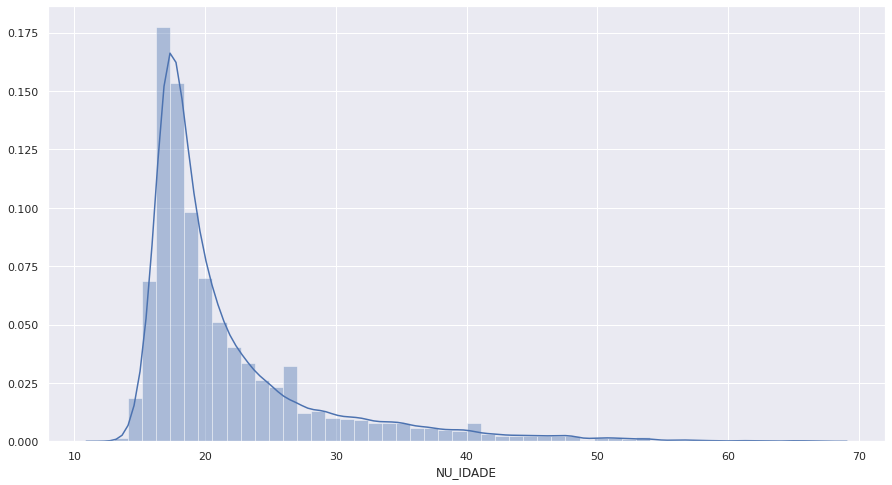

In [0]:
sns.distplot(train['NU_IDADE'])

In [0]:
cdf = round(sct.norm.cdf(25, train['NU_IDADE'].mean(), train['NU_IDADE'].std()), 2)
print(f'A probabiliade de ter um candidado com 25 anos ou menos é de {cdf*100:.2f}%')

A probabiliade de ter um candidado com 25 anos ou menos é de 69.00%


In [0]:
sf = round(sct.norm.sf(25, train['NU_IDADE'].mean(), train['NU_IDADE'].std()), 2)
print(f'A probabiliade de ter um candidado com 25 anos ou mais é de {sf*100:.2f}%')

A probabiliade de ter um candidado com 25 anos ou mais é de 31.00%


Vamos criar uma nova coluna, _NU_NOTA_PROVAS_, para realizarmos as análises

In [0]:
train['NU_NOTA_PROVAS'] = (train['NU_NOTA_CH'] + train['NU_NOTA_CN'] + train['NU_NOTA_LC'] + train['NU_NOTA_MT']) / 4

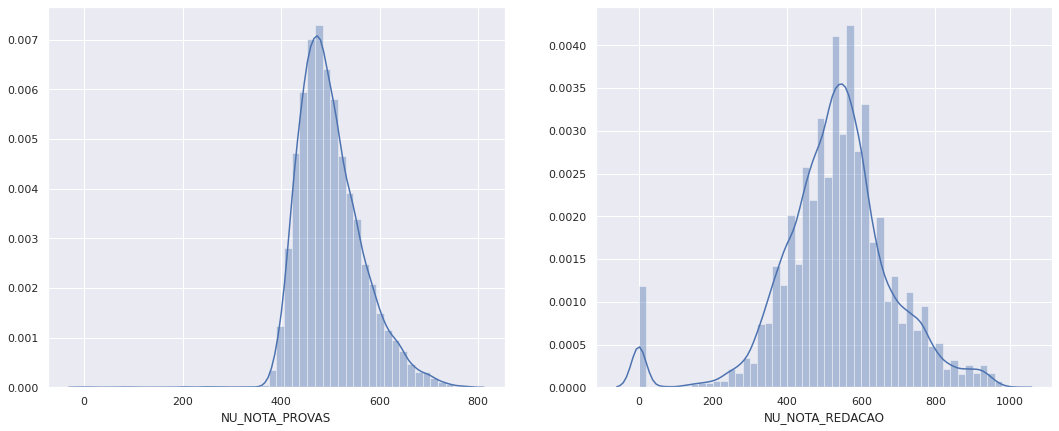

In [0]:
fig, axs = plt.subplots(1, 2, figsize=(18,7))
sns.distplot(train['NU_NOTA_PROVAS'], ax=axs[0])
sns.distplot(train['NU_NOTA_REDACAO'], ax=axs[1])

Observando o gráfico de notas da redação conseguimos identificar um nível considerável de notas com zero. O ENEM tem algumas situações em que o candidato pode tirar nota zero no caso de _Fuga ao tema_, _Texto insuficiente_, entre outros. Vamos verificar

In [0]:
redacao_index = train_df['TP_STATUS_REDACAO'].value_counts().index
redacao_values = train_df['TP_STATUS_REDACAO'].value_counts().values

redacao = pd.DataFrame({'tipo': redacao_index.astype(int), 'valores': redacao_values})

redacao['descricao'] = redacao['tipo'].map({1: 'Sem problemas',
                                        2: 'Anulada',
                                        3: 'Cópia texto motivador',
                                        4: 'Em branco',
                                        5: 'Fere direitos autorais',
                                        6: 'Fuga ao tema',
                                        7: 'Não atendimento ao tipo',
                                        8: 'Texto insuficiente',
                                        9: 'Parte desconectada'})

redacao[['valores', 'descricao']]

,valores,descricao
0,13195,Sem problemas
1,133,Em branco
2,105,Fuga ao tema
3,29,Parte desconectada
4,17,Cópia texto motivador
5,12,Texto insuficiente
6,9,Fere direitos autorais
7,7,Não atendimento ao tipo
8,3,Anulada


In [0]:
data = [go.Bar(y=redacao['valores'], 
               x=redacao['descricao'])]

layout = go.Layout(title='Situação da Redação')

fig = go.Figure(data=data, layout=layout)
fig.show()

In [0]:
sf_nota = sct.norm.sf(600, train['NU_NOTA_PROVAS'].mean(), train['NU_NOTA_PROVAS'].std())
print(f'A probabilidade de um candidato tirar nota maior ou igual a 600 na prova é de {sf_nota*100:.2f}%')

A probabilidade de um candidato tirar nota maior ou igual a 600 na prova é de 6.22%


In [0]:
sf_redacao = sct.norm.sf(700, train_df['NU_NOTA_REDACAO'].mean(), train_df['NU_NOTA_REDACAO'].std())
print(f'A probabilidade de um candidato tirar nota maior ou igual a 700 na redação é de {sf_redacao*100:.2f}%')

A probabilidade de um candidato tirar nota maior ou igual a 700 na redação é de 13.25%


Avaliando a distribuição das notas por estado, temos:

In [0]:
data = [go.Box(x=train['SG_UF_RESIDENCIA'], 
               y=train['NU_NOTA_PROVAS'])]

layout = go.Layout(title='Nota das provas por estado')

fig = go.Figure(data=data, layout=layout)
fig.show()

In [0]:
data = go.Box(x=train_df['SG_UF_RESIDENCIA'], 
              y=train_df['NU_NOTA_REDACAO'])
layout = go.Layout(title='Nota de redação por estado')

fig = go.Figure(data=data, layout=layout)
fig.show()

Observando o gráfico conseguimos identificar a diferença entre os candidados das instituições _públicas_ e _privadas_, no qual os candidatos da instituição _privada_ têm os valores bem consistentes, sem a presença de _outliers_ (valores fora do comum) e também com a média acima dos outros. Porém não podemos nos basear completamente nesse gráfico, veremos o porquê.

Text(0.5, 0, 'Tipo de escola do Ensino Médio')

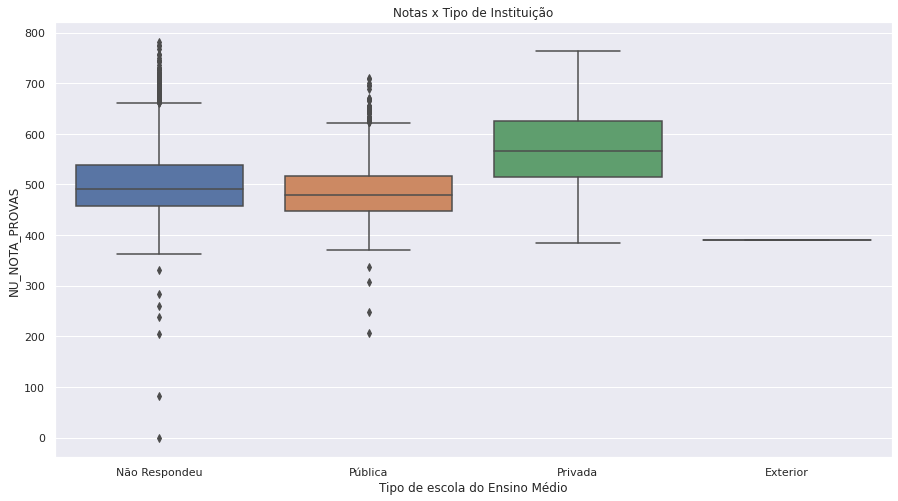

In [0]:
sns.boxplot(data=train, x='TP_ESCOLA', y='NU_NOTA_PROVAS')
plt.xticks(ticks=[0,1,2,3], labels=['Não Respondeu', 'Pública', 'Privada', 'Exterior'])
plt.title("Notas x Tipo de Instituição")
plt.xlabel('Tipo de escola do Ensino Médio')

A quantidade de candidatos que não responderam essa pergunta tem uma diferença muito grande das outras, sendo assim, se fizermos a análise somente pelo gráfico acima vamos estar enviesando nossa afirmação

Text(0.5, 0, 'Tipo de escola do Ensino Médio')

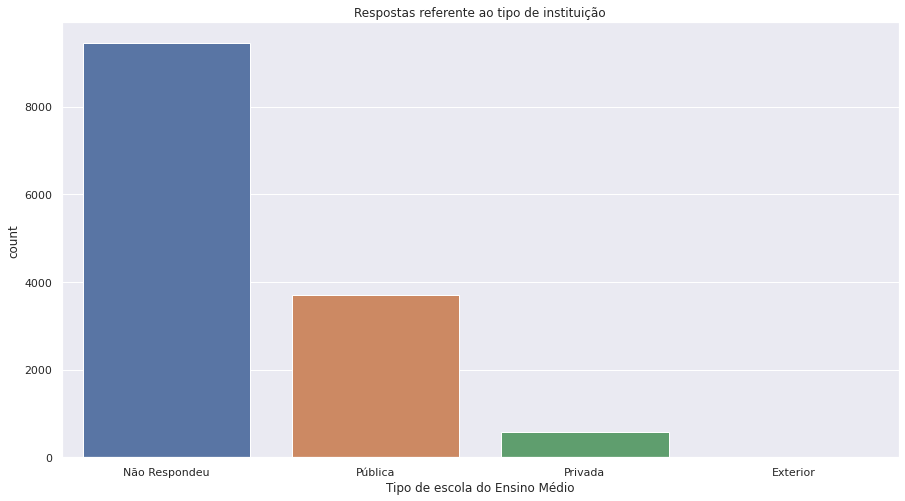

In [0]:
sns.countplot(train['TP_ESCOLA'])
plt.xticks(ticks=[0,1,2,3], labels=['Não Respondeu', 'Pública', 'Privada', 'Exterior'])
plt.title('Respostas referente ao tipo de instituição')
plt.xlabel('Tipo de escola do Ensino Médio')

Temos um questionário _sócio econômico_ que os candidados respondem. Vamos avaliar as respostas e verificar se pode haver alguma influência. __O título do gráfico corresponde as perguntas realizadas.__

Text(0, 0.5, '')

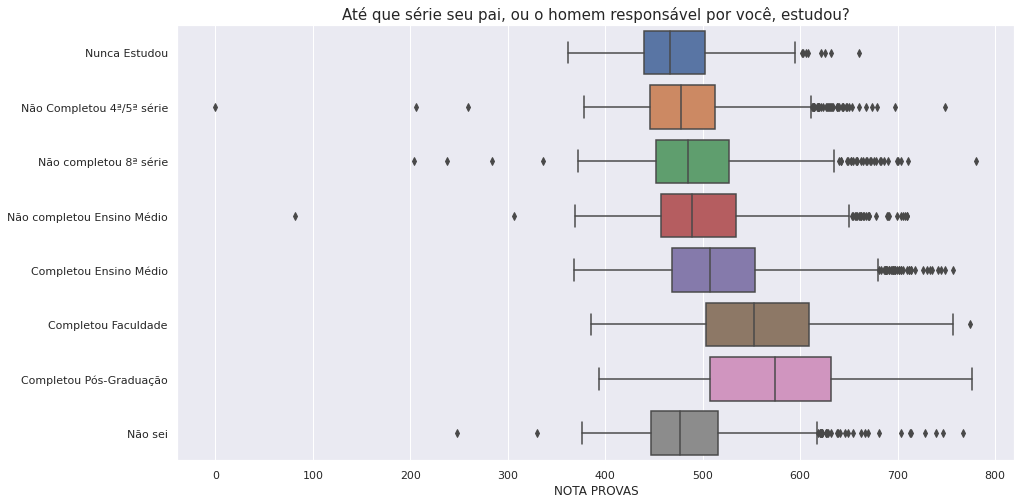

In [0]:
sns.boxplot(data=train, y='Q001', x='NU_NOTA_PROVAS', order='ABCDEFGH')
plt.title('Até que série seu pai, ou o homem responsável por você, estudou?', 
          {'fontsize':15})
plt.yticks(ticks=[0,1,2,3,4,5,6,7], 
           labels=['Nunca Estudou', 'Não Completou 4ª/5ª série', 'Não completou 8ª série',
                   'Não completou Ensino Médio', 'Completou Ensino Médio', 
                   'Completou Faculdade', 'Completou Pós-Graduação', 'Não sei'])
plt.xlabel("NOTA PROVAS")
plt.ylabel('')

Text(0, 0.5, '')

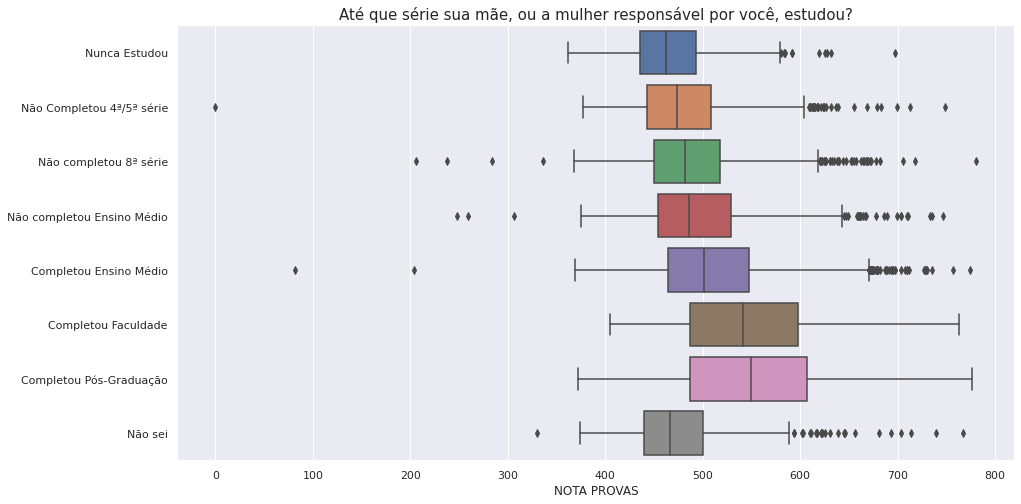

In [0]:
sns.boxplot(data=train, y='Q002', x='NU_NOTA_PROVAS', order='ABCDEFGH')
plt.title('Até que série sua mãe, ou a mulher responsável por você, estudou?',
          {'fontsize':15})
plt.yticks(ticks=[0,1,2,3,4,5,6,7], 
           labels=['Nunca Estudou', 'Não Completou 4ª/5ª série', 'Não completou 8ª série',
                   'Não completou Ensino Médio', 'Completou Ensino Médio', 
                   'Completou Faculdade', 'Completou Pós-Graduação', 'Não sei'])
plt.xlabel("NOTA PROVAS")
plt.ylabel('')

Observamos um aumento na nota quando vamos aumentamos a faixa da renda mensal da família

Text(0, 0.5, '')

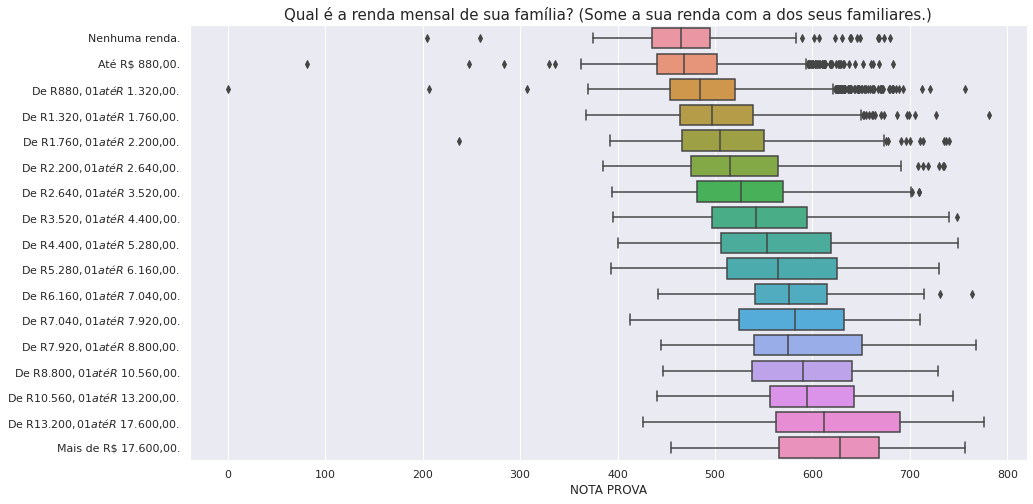

In [0]:
sns.boxplot(data=train, y='Q006', x='NU_NOTA_PROVAS', 
            order='ABCDEFGHIJKLMNOPQ')
plt.title('Qual é a renda mensal de sua família? (Some a sua renda com a dos seus familiares.)',
          {'fontsize':15})
renda = ['Nenhuma renda.', 'Até R$ 880,00.', 'De R$ 880,01 até R$ 1.320,00.', 'De R$ 1.320,01 até R$ 1.760,00.',
         'De R$ 1.760,01 até R$ 2.200,00.', 'De R$ 2.200,01 até R$ 2.640,00.', 'De R$ 2.640,01 até R$ 3.520,00.',
         'De R$ 3.520,01 até R$ 4.400,00.', 'De R$ 4.400,01 até R$ 5.280,00.', 'De R$ 5.280,01 até R$ 6.160,00.',
         'De R$ 6.160,01 até R$ 7.040,00.', 'De R$ 7.040,01 até R$ 7.920,00.', 'De R$ 7.920,01 até R$ 8.800,00.',
         'De R$ 8.800,01 até R$ 10.560,00.', 'De R$ 10.560,01 até R$ 13.200,00.', 'De R$ 13.200,01 até R$ 17.600,00.',
         'Mais de R$ 17.600,00.']
plt.yticks([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16], renda)
plt.xlabel("NOTA PROVA")
plt.ylabel('')

Text(0, 0.5, '')

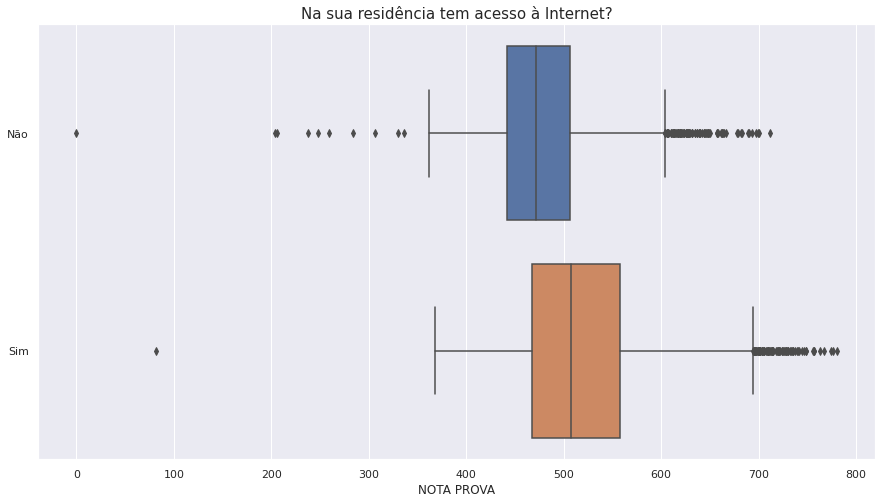

In [0]:
sns.boxplot(data=train, y='Q025', x='NU_NOTA_PROVAS')
plt.title('Na sua residência tem acesso à Internet?',
          {'fontsize':15})
plt.yticks([0,1], ['Não', 'Sim'])
plt.xlabel('NOTA PROVA')
plt.ylabel('')

Text(0, 0.5, '')

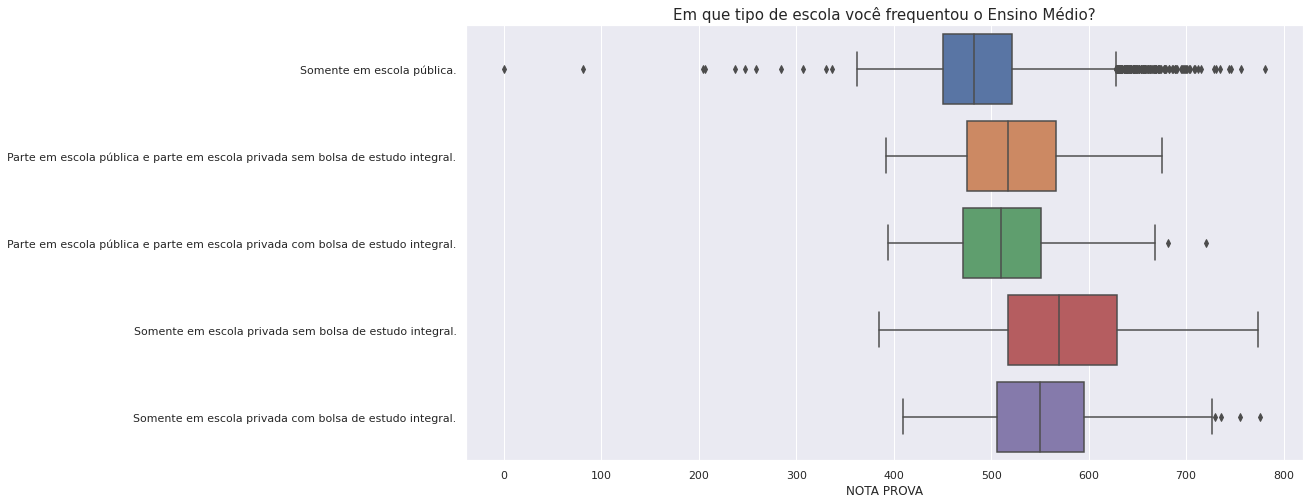

In [0]:
sns.boxplot(data=train, y='Q047', x='NU_NOTA_PROVAS', order='ABCDE')
plt.title('Em que tipo de escola você frequentou o Ensino Médio?',
          {'fontsize':15})
plt.xlabel('NOTA PROVA')
tipo_escola = ['Somente em escola pública.', 'Parte em escola pública e parte em escola privada sem bolsa de estudo integral.',
               'Parte em escola pública e parte em escola privada com bolsa de estudo integral.', 'Somente em escola privada sem bolsa de estudo integral.',
               'Somente em escola privada com bolsa de estudo integral.']
plt.yticks([0,1,2,3,4], tipo_escola)
plt.ylabel('')

Como será que ficou a presença dos alunos nesse ano de 2016? 

Os números estão bem próximos e não vamos exibi-los através de gráficos, uma vez que não vamos conseguir identificar a diferença entre eles. Mas observando abaixo temos que _Linguagem e Matemática_ tem números iguais, e também são iguais _Ciências Humanas e Ciências da Natureza_

In [0]:
print('Legenda:\n')
print('1: Presente na prova / 0: Faltou à prova / 2: Eliminado na prova \n')
print(train['TP_PRESENCA_LC'].value_counts())
print(train['TP_PRESENCA_MT'].value_counts())
print('---'*15)
print(train['TP_PRESENCA_CH'].value_counts())
print(train['TP_PRESENCA_CN'].value_counts())

Legenda:

1: Presente na prova / 0: Faltou à prova / 2: Eliminado na prova 

1    10133
0     3592
2        5
Name: TP_PRESENCA_LC, dtype: int64
1    10133
0     3592
2        5
Name: TP_PRESENCA_MT, dtype: int64
---------------------------------------------
1    10341
0     3380
2        9
Name: TP_PRESENCA_CH, dtype: int64
1    10341
0     3380
2        9
Name: TP_PRESENCA_CN, dtype: int64


O ENEM no ano de 2016 foi realizado em dois dias (conforme site do [INEP](http://portal.inep.gov.br/artigo/-/asset_publisher/B4AQV9zFY7Bv/content/chegou-a-hora-do-enem-2016/21206)). No primeiro dia foram feitas as provas de _Ciências Humanas e suas Tecnologias e Ciências da Natureza e suas Tecnologias_, no segundo _Linguagens, Códigos e suas Tecnologias, Redação e Matemática e suas Tecnologias_. Ou seja, o candidado que não estava presente na redação provavelmente não estará na avaliação de matemática e linguagens.

### Vamos partir agora para a inputação e tratamento dos dados

In [0]:
base[base.nulos > 0].sort_values(['nulos', 'coluna'])

,coluna,tipo,nulos,size,unicos
16,NU_NOTA_CH,float64,0.247077,13783,3193
15,NU_NOTA_CN,float64,0.247077,13783,2872
31,TP_PRESENCA_MT,float64,0.249973,13730,3
20,NU_NOTA_COMP1,float64,0.261991,13510,15
21,NU_NOTA_COMP2,float64,0.261991,13510,13
22,NU_NOTA_COMP3,float64,0.261991,13510,12
23,NU_NOTA_COMP4,float64,0.261991,13510,14
24,NU_NOTA_COMP5,float64,0.261991,13510,14
17,NU_NOTA_LC,float64,0.261991,13510,2939
25,NU_NOTA_REDACAO,float64,0.261991,13510,53


A quantidade de valores nulos nessas _features_ são bem parecidos. Como comentamos anteriormente, pode ser que algum candidato foi excluido ou esteve ausente nas provas ou da redação.

In [0]:
# Passando a lista de colunas para a variável
colunas_base = base[base.nulos > 0].sort_values(['nulos', 'coluna'])['coluna'].tolist()
colunas_base

['NU_NOTA_CH',
 'NU_NOTA_CN',
 'TP_PRESENCA_MT',
 'NU_NOTA_COMP1',
 'NU_NOTA_COMP2',
 'NU_NOTA_COMP3',
 'NU_NOTA_COMP4',
 'NU_NOTA_COMP5',
 'NU_NOTA_LC',
 'NU_NOTA_REDACAO',
 'TP_STATUS_REDACAO',
 'NU_NOTA_MT',
 'TP_DEPENDENCIA_ADM_ESC',
 'TP_ENSINO']

In [0]:
# imputando o valor 0 para os candidatos que estão com o status diferente de "1 = Presente na prova"
train_df.loc[train_df['TP_PRESENCA_CH'] != 1, 'NU_NOTA_CH'] = train_df.loc[train_df['TP_PRESENCA_CH'] != 1, 'NU_NOTA_CH'].fillna(0)
train_df.loc[train_df['TP_PRESENCA_CN'] != 1, 'NU_NOTA_CN'] = train_df.loc[train_df['TP_PRESENCA_CN'] != 1, 'NU_NOTA_CN'].fillna(0)
train_df.loc[train_df['TP_PRESENCA_MT'] != 1, 'NU_NOTA_MT'] = train_df.loc[train_df['TP_PRESENCA_MT'] != 1, 'NU_NOTA_MT'].fillna(0)
train_df.loc[train_df['TP_PRESENCA_LC'] != 1, 'NU_NOTA_LC'] = train_df.loc[train_df['TP_PRESENCA_LC'] != 1, 'NU_NOTA_LC'].fillna(0)

train_df.loc[train_df['TP_PRESENCA_LC'] != 1, 'NU_NOTA_REDACAO'] = train_df.loc[train_df['TP_PRESENCA_LC'] != 1, 'NU_NOTA_REDACAO'].fillna(0)
train_df.loc[train_df['TP_PRESENCA_LC'] != 1, 'NU_NOTA_COMP1'] = train_df.loc[train_df['TP_PRESENCA_LC'] != 1, 'NU_NOTA_COMP1'].fillna(0)
train_df.loc[train_df['TP_PRESENCA_LC'] != 1, 'NU_NOTA_COMP2'] = train_df.loc[train_df['TP_PRESENCA_LC'] != 1, 'NU_NOTA_COMP2'].fillna(0)
train_df.loc[train_df['TP_PRESENCA_LC'] != 1, 'NU_NOTA_COMP3'] = train_df.loc[train_df['TP_PRESENCA_LC'] != 1, 'NU_NOTA_COMP3'].fillna(0)
train_df.loc[train_df['TP_PRESENCA_LC'] != 1, 'NU_NOTA_COMP4'] = train_df.loc[train_df['TP_PRESENCA_LC'] != 1, 'NU_NOTA_COMP4'].fillna(0)
train_df.loc[train_df['TP_PRESENCA_LC'] != 1, 'NU_NOTA_COMP5'] = train_df.loc[train_df['TP_PRESENCA_LC'] != 1, 'NU_NOTA_COMP5'].fillna(0)

In [0]:
# alterando o variável TP_SEXO
train_df['TP_SEXO'] = train_df['TP_SEXO'].map({'M': 1, 'F': 0})

Como temos as variáveis categóricas referente ao questionário, vamos utilizar o _LabelEncoder_ para transformar esses dados em números inteiros, uma vez que os modelos de _Machine Learning_ não conseguem trabalhar com dados categóricos.

In [0]:
label_encoder = LabelEncoder()

train_df['Q001'] = label_encoder.fit_transform(train_df['Q001'])
train_df['Q002'] = label_encoder.fit_transform(train_df['Q002'])
train_df['Q006'] = label_encoder.fit_transform(train_df['Q006'])
train_df['Q025'] = label_encoder.fit_transform(train_df['Q025'])
train_df['Q047'] = label_encoder.fit_transform(train_df['Q047'])

Exibindo o mapa de correlação novamente, temos agora novas _features_ com forte correlação.

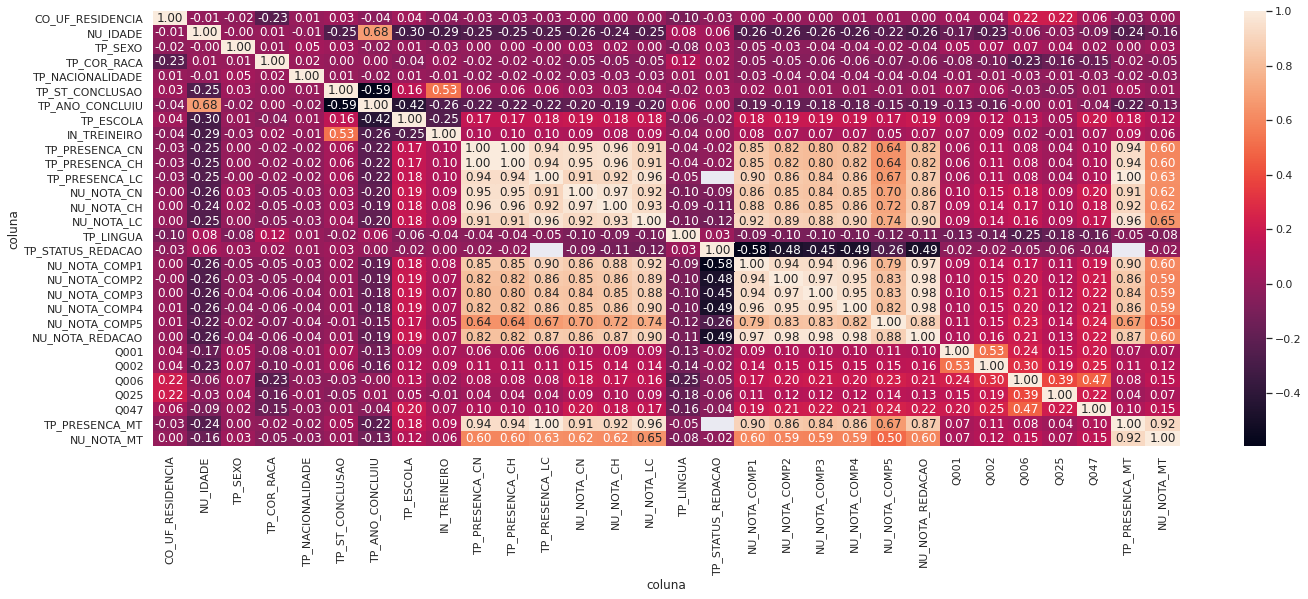

In [0]:
correlacao(train_df)

Temos algumas *features* com uma boa correlação, que é o ideal de trabalharmos, com isso vamos fazer algumas eliminações.

In [0]:
train_df.drop(['SG_UF_RESIDENCIA', 'TP_SEXO', 'TP_COR_RACA', 'TP_NACIONALIDADE', 'TP_ST_CONCLUSAO', 'TP_ANO_CONCLUIU', 
               'TP_LINGUA', 'TP_STATUS_REDACAO', 'Q001', 'Q002', 'Q006', 'Q025', 'Q047'], 
              axis=1, inplace=True)

''' 
## Features que foram removidas para utilizar no modelo de deploy

train_df.drop(['SG_UF_RESIDENCIA', 'TP_SEXO', 'TP_COR_RACA', 'TP_NACIONALIDADE', 'TP_ST_CONCLUSAO', 'TP_ANO_CONCLUIU', 
               'TP_LINGUA', 'TP_STATUS_REDACAO', 'NU_NOTA_COMP1', 'NU_NOTA_COMP2', 'NU_NOTA_COMP3', 'NU_NOTA_COMP4',
               'NU_NOTA_COMP5', 'Q001', 'Q002', 'Q006', 'Q025', 'Q047'], 
              axis=1, inplace=True)
'''

" \n## Features que foram removidas para utilizar no modelo de deploy\n\ntrain_df.drop(['SG_UF_RESIDENCIA', 'TP_SEXO', 'TP_COR_RACA', 'TP_NACIONALIDADE', 'TP_ST_CONCLUSAO', 'TP_ANO_CONCLUIU', \n               'TP_LINGUA', 'TP_STATUS_REDACAO', 'NU_NOTA_COMP1', 'NU_NOTA_COMP2', 'NU_NOTA_COMP3', 'NU_NOTA_COMP4',\n               'NU_NOTA_COMP5', 'Q001', 'Q002', 'Q006', 'Q025', 'Q047'], \n              axis=1, inplace=True)\n"

In [0]:
# Recuperando nosso dataset
train = train_df.iloc[:train_idx]
test = train_df.iloc[train_idx:]

# Salvando a variável para realizar o treino futuramente
target = train['NU_NOTA_MT']

train.drop(['NU_NOTA_MT', 'TP_PRESENCA_MT'], axis=1, inplace=True)
test.drop(['NU_NOTA_MT','TP_PRESENCA_MT'], axis=1, inplace=True)

### Trabalhando com os modelos de Machine Learning

Iremos utilizar aqui dois modelos que são _Linear Regression_ e *Random Forest Regressor*, pois estamos querendo fazer a predição da nota de matemática. Não podemos dizer que um modelo é melhor, mas sim que um se adequa melhor do que o outro ao que foi proposto.

Conforme a imagem abaixo teriamos outros modelos para utilizar e verificar qual seria mais adequado, porém vamos focar apenas nos dois citados anteriormente

![Machine Learning](https://dl.dropbox.com/s/m3b6wesb0rxtkjo/machine_learning.jpeg?dl=0)

1. Não temos que reduzir a dimensionalidade, fizemos isso manualmente.
2. Temos nossa _feature_ de resposta.
3. Iremos realizar a predição numérica.

Temos então nosso aprendizado de regressão supervisionado.


_Linear Regression_

In [0]:
lr = LinearRegression()
lr.fit(train, target)

lr_score = lr.score(train, target)
print(f'Acurácia do modelo: {lr_score*100:.2f}%')

Acurácia do modelo: 90.99%


_Random Forest Regressor_

In [0]:
rf = RandomForestRegressor(n_jobs=-1)
rf.fit(train, target)

rf_score = rf.score(train, target)
print(f'Acurácia do modelo: {rf_score*100:.2f}%')

Acurácia do modelo: 98.86%


Depois de treinarmos nosso modelo vamos agora salva-lo para realizarmos o deploy (utilizaremos o *Random Forest* por ter ficado com uma acurácia melhor que a Regressão Linear) para isso basta utilizarmos a biblioteca *pickle*.

In [0]:
# pickle.dump(rf, open('model.pkl', 'wb'))

>*obs.: Para nosso deploy removi as variáveis NU_NOTA_COMP1 até NU_NOTA_COMP5 ficando com menos informações para inserir e não ficar cansativo, para acessar [clique aqui](https://portfolio-enem.herokuapp.com/)*